### **Aim:** Predict the high price of Bitcoin based on a collection of features. 


In [1]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import normalize
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from sklearn.metrics import r2_score

import requests
from datetime import datetime

# Data Context

### <u>Target</u>
**High:** Highest price traded during a time period.


### <u>Features</u>
**Open:** Price at the first trade in the time period.

**Low:** Lowest price traded during a time period.

**Volume by Currency:** The total value of Bitcoin that was traded in a specific currency, such as US dollars (in our case). *demand*

---
**We will not be using the below features, but they are provided for completeness.**

**Close:** Price at the last trade in the time period.

**Volume BTC:** The total amount of Bitcoin that was traded during a specified time period. *activity/liquidity*

**Weighted Price:** The average price of the cryptocurrency that takes into account the total volume of trades that have occurred at different prices.

In [2]:
features = ["Open", "Low", "Volume_USD"]
target = "High"

In [3]:
df = pd.read_csv("/kaggle/input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.rename(columns = {'Volume_(Currency)':'Volume_USD'}, inplace = True)
df = df[df.columns.intersection(features + [target] + ["Timestamp"])]
df.shape

(4857377, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Timestamp   int64  
 1   Open        float64
 2   High        float64
 3   Low         float64
 4   Volume_USD  float64
dtypes: float64(4), int64(1)
memory usage: 185.3 MB


# Data Cleaning
- Handle missing values
- Downcast value types to save space
- Ensure time series has equidistant times

In [6]:
df.isna().sum()

Timestamp           0
Open          1243608
High          1243608
Low           1243608
Volume_USD    1243608
dtype: int64

This dataset only inputs values when their unique, the NaNs are to be forward-filled

In [7]:
df.fillna(method="ffill", inplace=True)
df.isna().sum()

Timestamp     0
Open          0
High          0
Low           0
Volume_USD    0
dtype: int64

# Data Preprocessing
- Downcast column types (save memory)
- Evaluate our timeseries' interval distance

In [8]:
fcols = df.select_dtypes('float').columns
icols = df.select_dtypes('integer').columns

df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Timestamp   int32  
 1   Open        float32
 2   High        float32
 3   Low         float32
 4   Volume_USD  float32
dtypes: float32(4), int32(1)
memory usage: 92.6 MB


Let's add a readable datetime format

In [9]:
df['Date'] = pd.to_datetime(df['Timestamp'], unit='s')
df['Gap (> 1 min)'] = (df.Date - df.Date.shift(1)) > pd.to_timedelta('1 min')

big_gap = df[df['Gap (> 1 min)']]
big_gap.head()

,Timestamp,Open,High,Low,Volume_USD,Date,Gap (> 1 min)
1585521,1420837500,272.450012,305.0,272.450012,50502.066406,2015-01-09 21:05:00,True


Ensuring our time-series has equidistant entries

In [10]:
# Percentage below big gap
1585521/len(df)

0.3264150589917151

Lets take the data after the gap (larger portion)

In [11]:
df = df[1585522:].copy()
df['Gap (> 1 min)'].describe()

count     3271855
unique          1
top         False
freq      3271855
Name: Gap (> 1 min), dtype: object

# Representation

Lets see how our features relate to each other and how they are distributed (histograms)

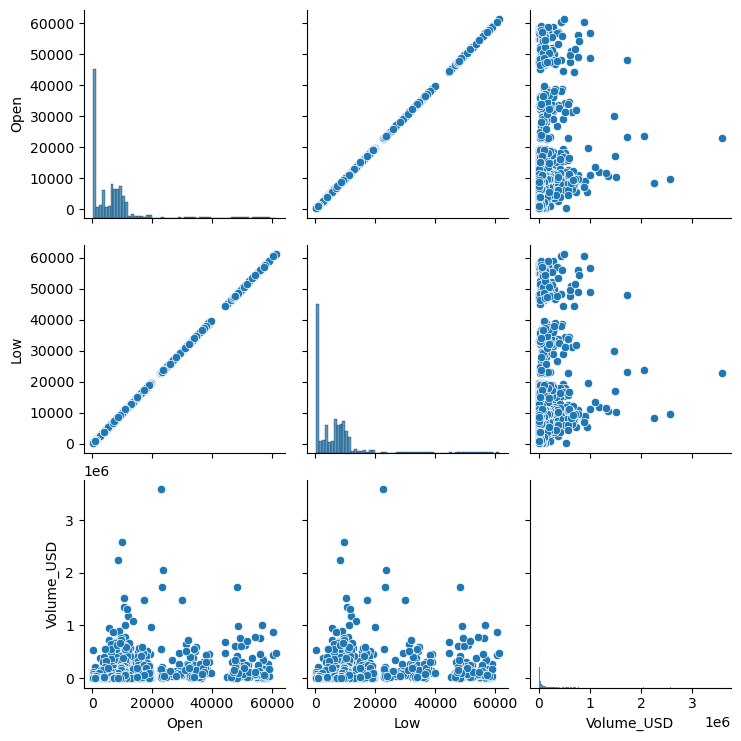

In [12]:
sns.pairplot(df[features].sample(5000)) # Our dataset is too big to pairplot the whole thing

Let's check the correlation between feautures

Text(0.5, 1.0, 'Feature Correlation Plot')

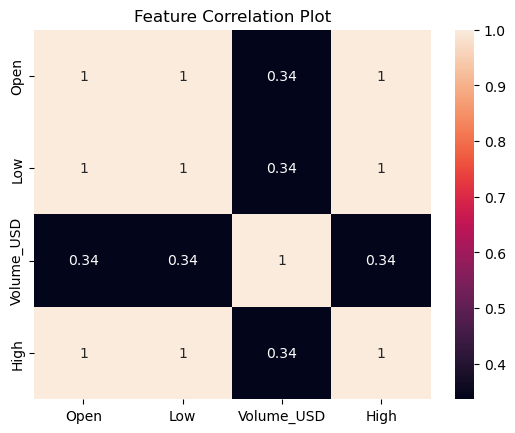

In [13]:
sns.heatmap(df[features + [target]].corr(), annot=True)
plt.title("Feature Correlation Plot")

# Feature Selection
Lets check our feature variance to decide on features to use, We're also going to need to normalise our data temporarily so that the ranges do not skew our analysis.
Features with high variances elicit better results with models.

In [14]:
df = df[features + [target]] # ignore redundant columns for regression (Timestamp, Date, Gap)

In [15]:
norm_df = pd.DataFrame(normalize(df))
norm_df.var() # variances 

0    0.042057
1    0.042046
2    0.142021
3    0.042069
dtype: float32

Variances are suitable so we will stick to the features

# Train Test Split

In [16]:
x_train, x_test, y_train, y_test = train_test_split(df[features], df[target], test_size = 0.3, random_state=0)

# Model
Fit model to our training data

In [17]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

# Prediction
Let's predict a target value based on features with a random sample!

In [18]:
sample_row = df.sample(1) # Pick a sample row randomly from the dataframe
input_data = sample_row[features] # Model input of features
sample_row[target] # Our target ground truth

1970989    239.229996
Name: High, dtype: float32

In [19]:
prediction = model.predict(input_data)
prediction[0] # target based in regression model

238.25453

# Performance
- Cross Validation
- Residual Graph
- $R^2$ measure

### Cross validation
This measure can tell us how well the model may perform on unseen data.

In [20]:
scores = cross_val_score(model, x_train, y_train, cv=10)

print("Cross-validation scores:", scores)
print("Mean score:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation scores: [0.9999986  0.99999872 0.99999868 0.99999854 0.99999855 0.9999985
 0.99999863 0.99999855 0.99999863 0.99999857]
Mean score: 0.999998598304904
Standard deviation: 6.462399950503963e-08


### Residual Graph 
This plot can show us if this model is well suited to this data.

**What is a residual?**
- Difference between predicted value and actual value
- Residual > 0: data point is above regression line
- Residual < 0: data point is below regression line

**Characteristics of a good model:**
- Randomness: residuals that are randomly scattered around the red line.
- Homoscedasticity:residuals that are evenly spread out around the red line.
- Normality: residuals that follow a normal distribution (the assumption that the data has normality)

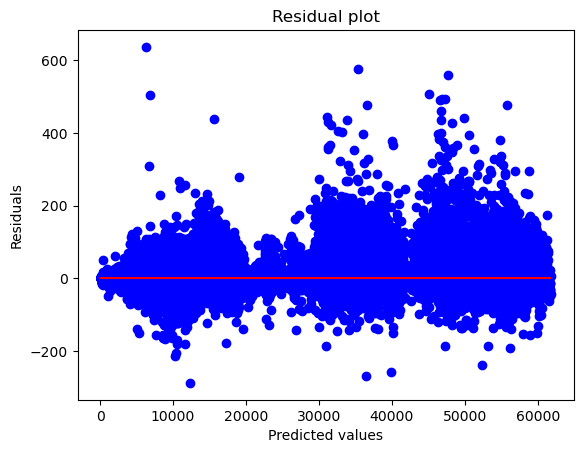

In [21]:
y_prediction = model.predict(x_test)
residuals = y_test - y_prediction

plt.scatter(y_prediction, residuals, color='blue')
plt.hlines(y=0, xmin=0, xmax=max(y_prediction), color='red')
plt.title('Residual plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

### **How does our model fare?**
Our model scores highly in the cross validation.

In terms of Residuals:
- **Randomness:** Our incorrect values do not all go in the same direction or by the same amount and so the randomness is good and shows little bias.
- **Homoscedasticity:** The residuals cloud the horizontal line in an even manner showing little bias across features
- **Normality:** Let's evaluate this with a QQ plot

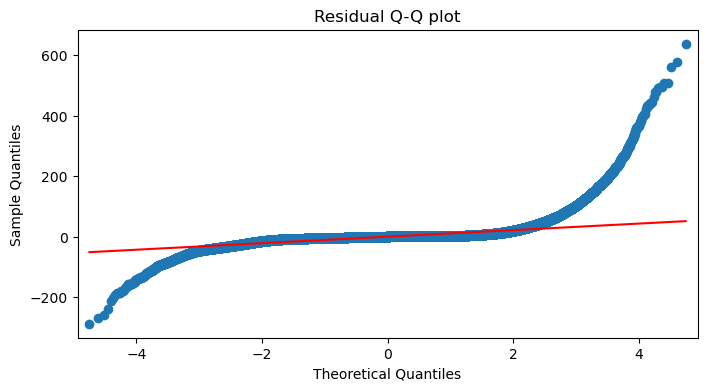

In [22]:
fig, ax = plt.subplots(figsize=(8, 4))
sm.qqplot(residuals, line='s', ax=ax)
ax.set_title('Residual Q-Q plot')
plt.show()

This plot compares the residual distribution to a normal distribution.

It shows our residuals have a heavy tail.
This tells us that there are potential extremes that the model would not expect.
It also may imply that there are external actors or features that affect the dataset that our model does not account for.

### $R^2$

he proportion of variance in the target that is explained by the features in the regression model.

In [23]:
r2_score(y_prediction, y_test)

0.9999986386186023

# Application
Let's pull in some real bitcoin data and see how close we are!

In [24]:
response = requests.get("https://min-api.cryptocompare.com/data/v2/histoday?fsym=BTC&tsym=USD&limit=1")  
data = response.json()["Data"]["Data"][0]

In [25]:
time = str(pd.to_datetime(data["time"], unit='s'))
open_price = data["open"]
low_price = data["low"]
vol_usd = data["volumefrom"]

latest = pd.DataFrame([[open_price, low_price, vol_usd]], columns=features)

print("Time: " + time)
print("Open: " + str(open_price))
print("Low: " + str(low_price))
print("USD Volume: " + str(vol_usd))

Time: 2023-02-27 00:00:00
Open: 23557.39
Low: 23144.28
USD Volume: 44498.06


In [26]:
prediction = model.predict(latest)[0]
actual_high = data["high"]
error_usd = round(abs(actual_high - prediction), 2)

print("Prediction: $" + str(round(prediction,2)))
print("Actual: $" + str(actual_high))
print("Error: $" + str(error_usd))

Prediction: $23456.61
Actual: $23876.65
Error: $420.04
